# Classification results

## Included sections:

### Features ranking calculation

Feature ranking applying a chi-squared filtering method that evaluates the correlation between variables (features and target classes) and ranks them according to their contribution to the prediction.


### F1 vs Features plot (from saved files)

Model performance evolution, measured by the F1-Score, according to the selected number of features.

### Recall, precision, F1 and accuracy metrics calculation 

Performance of all the analyzed supervised machine learning approaches based on four metrics:

* Precision: true positives among all positive results)

* Recall: correct labeled positives based on all the correct positive and negative events

* F1 Score: the harmonic mean of precision and recall metrics

* Accuracy: the ratio of correct prediction over the total number of predictions



In [1]:
import os
os.environ['PYTHONHASHSEED'] = '1'
from numpy.random import seed
seed(1)
import random as rn
rn.seed(1)


import warnings
warnings.filterwarnings("ignore")


import sys
import glob
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib import cm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from scipy.stats import kurtosis 
from scipy.stats import skew
from sklearn.neural_network import MLPClassifier 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import metrics
from sklearn.svm import SVC
from sklearn import tree
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from IPython.display import display
import matplotlib.style as style 
from sklearn.pipeline import Pipeline       
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import ast

import gc





## Variables set up

In [2]:
#Number of signal components 
#(3 for XYZ, 1 for X)
number_components = 3

#Best feature number 
#(Max 162 for XYZ, 54 for X)
best_features_number=162

#Average results for n_times
n_times = 100

#Dataset folder relative route
root = '../HMP_Dataset/' #Regular Sampling
#root = '../HMP_Dataset_Downsample/' #Downsample

## Data processing

In [3]:
#Create activities dictionary 
wrist_class = {'Brush_teeth':0, 
              'Climb_stairs':4, 
              'Comb_hair':2, 
              'Descend_stairs':3, 
              'Drink_glass':1, 
              'Eat_meat':5, 
              'Eat_soup':6, 
              'Getup_bed':7, 
              'Liedown_bed':8, 
              'Pour_water':9, 
              'Sitdown_chair':10, 
              'Standup_chair':11, 
              'Use_telephone':12, 
              'Walk':13
             }

#Binarization dictionary
wrist_class_binary = {'Other':0, 
               'Drink_glass':1, 
             }
                
                
#Activity label list
wrist_labels = sorted(wrist_class, key=lambda x: x[1])
wrist_labels_binary = sorted(wrist_class_binary, key=lambda x: x[1], reverse=True) 


#Funtion to import all the txt for every class, calculate its features and append it in a Matrix
def gather(class_dict):
    df = []
    for c in class_dict.keys():
        f = glob.glob(root + c + '/*') #Get all files 
        d = pd.DataFrame(reformat(f, cls=c)) #Pandas dataframe for reformat funtion features
        df.append(d)
    return pd.concat(df)


#Median Filter axiliar function 
def strided_app(a, L, S ):  # Window len = L, Stride len/stepsize = S
    nrows = ((a.size-L)//S)+1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a, shape=(nrows,L), strides=(S*n,n)) 



#Obtain Data values for every secuence/instance
def reformat(files, cls):
    big_list= []
    
    for f in files:
        #Read every txt file (Number of row value_x, Value_Y, Value_Z)
        data = pd.read_csv(f, sep=' ', header=None, names=['x', 'y', 'z']) 
       
        #Conversion from 0-63 to m/s^2
        df_x = -14.709 + (data.iloc[:,0:1]/63)*(2*14.709)
        df_y = -14.709 + (data.iloc[:,1:2]/63)*(2*14.709)
        df_z = -14.709 + (data.iloc[:,2:3]/63)*(2*14.709)
        
        
        #Median filter
        x = np.median(strided_app(df_x.values.flatten(), 3,1),axis=1)
        y = np.median(strided_app(df_y.values.flatten(), 3,1),axis=1)
        z = np.median(strided_app(df_z.values.flatten(), 3,1),axis=1)
        
        df_x = pd.DataFrame(x, columns=['x'])
        df_y = pd.DataFrame(y, columns=['y'])
        df_z = pd.DataFrame(z, columns=['z'])
        
        
        data_all=pd.concat([df_x.reset_index(drop=True), df_y.reset_index(drop=True), df_z.reset_index(drop=True)], axis=1)
        
        
        data_reduced = data_all.iloc[:,0:number_components]

        #Split selected component of every secuence in X segments
        split_index=5 #Number of segments
        data_split=np.array_split(data_reduced, split_index)
        
        appended_features=[]
        
        #Features calculation
        features_whole = pd.concat([data_reduced.mean(axis=0).rename(index=lambda x: 'mean' + '_' + x), 
                              #Dataframe 
                              data_reduced.std(axis=0).rename(index=lambda x: 'std' + '_' + x),
                              data_reduced.median(axis=0).rename(index=lambda x: 'median' + '_' + x), 
                              data_reduced.mad(axis=0).rename(index=lambda x: 'mad' + '_' + x), 
                              data_reduced.max(axis=0).rename(index=lambda x: 'max' + '_' + x),
                              data_reduced.kurtosis(axis=0).rename(index=lambda x: 'kur' + '_' + x),  
                              data_reduced.skew(axis=0).rename(index=lambda x: 'skw' + '_' + x), 
                              data_reduced.var(axis=0).rename(index=lambda x: 'var' + '_' + x),   
                              data_reduced.min(axis=0).rename(index=lambda x: 'min' + '_' + x)])
        
        for i in range(0, split_index):
            #Features for every segment of data
            features= pd.concat([data_split[i].mean(axis=0).rename(index=lambda x: 'mean' + '_' + x + '_' + str(i)), 
                              data_split[i].std(axis=0).rename(index=lambda x: 'std' + '_' + x + '_' + str(i)),
                              data_split[i].median(axis=0).rename(index=lambda x: 'median' + '_' + x + '_' + str(i)), 
                              data_split[i].mad(axis=0).rename(index=lambda x: 'mad' + '_' + x + '_' + str(i)), 
                              data_split[i].max(axis=0).rename(index=lambda x: 'max' + '_' + x + '_' + str(i)),
                              data_split[i].kurtosis(axis=0).rename(index=lambda x: 'kur' + '_' + x + '_' + str(i)),  
                              data_split[i].skew(axis=0).rename(index=lambda x: 'skw' + '_' + x + '_' + str(i)),
                              #data_split[i].sum(axis=0).rename(index=lambda x: 'sum' + '_' + x + '_' + str(i)), 
                              data_split[i].var(axis=0).rename(index=lambda x: 'var' + '_' + x + '_' + str(i)),
                              data_split[i].min(axis=0).rename(index=lambda x: 'min' + '_' + x + '_' + str(i))])
            appended_features.append(features)
        
        #Concat all obtained features
        appended_features_all = pd.concat([features_whole,appended_features[0], appended_features[1], appended_features[2],appended_features[3],appended_features[4]])      #                
        
        #Binarize detectiom
        if wrist_class[cls] != 1:
            wrist_class[cls] = 0 #Other classes than drink are considered as CLASS 0. Drink = CLASS 1
        
        #Access to dictionary class number and add it as a feature
        appended_features_all['Y'] = wrist_class[cls]
        big_list.append(appended_features_all)

    #Return table containing all rows for every class and feature colums 
    #(mean*3, sd*3, Max*3, Min*3, Y). Number of the row is manteined. (0~101)
    return big_list





In [4]:
#Feature table for all classes
wrist_df = gather(wrist_class)

#Extact number of the class (feature Y)
wrist_Y = np.asarray(wrist_df.Y)

#Total number of features
num_features=len(wrist_df.columns)-1
print ('Total features: {}'.format(num_features))

#Extact rest of colums (features)
wrist_X = np.asarray(wrist_df.iloc[:,:num_features])

#Normalize data (0-1)
min_max_scaler = preprocessing.MinMaxScaler()
wrist_X= min_max_scaler.fit_transform(wrist_df.iloc[:,:num_features])
wrist_X_df = pd.DataFrame(wrist_X, columns=(wrist_df.iloc[:,:num_features]).columns)


#print zip (wrist_X_df['min_x_2'], wrist_df['Y'])
all_features = num_features 
print ("Feature names  " + str(wrist_df.iloc[:,:num_features].columns.values.tolist()))

Total features: 162
Feature names  ['mean_x', 'mean_y', 'mean_z', 'std_x', 'std_y', 'std_z', 'median_x', 'median_y', 'median_z', 'mad_x', 'mad_y', 'mad_z', 'max_x', 'max_y', 'max_z', 'kur_x', 'kur_y', 'kur_z', 'skw_x', 'skw_y', 'skw_z', 'var_x', 'var_y', 'var_z', 'min_x', 'min_y', 'min_z', 'mean_x_0', 'mean_y_0', 'mean_z_0', 'std_x_0', 'std_y_0', 'std_z_0', 'median_x_0', 'median_y_0', 'median_z_0', 'mad_x_0', 'mad_y_0', 'mad_z_0', 'max_x_0', 'max_y_0', 'max_z_0', 'kur_x_0', 'kur_y_0', 'kur_z_0', 'skw_x_0', 'skw_y_0', 'skw_z_0', 'var_x_0', 'var_y_0', 'var_z_0', 'min_x_0', 'min_y_0', 'min_z_0', 'mean_x_1', 'mean_y_1', 'mean_z_1', 'std_x_1', 'std_y_1', 'std_z_1', 'median_x_1', 'median_y_1', 'median_z_1', 'mad_x_1', 'mad_y_1', 'mad_z_1', 'max_x_1', 'max_y_1', 'max_z_1', 'kur_x_1', 'kur_y_1', 'kur_z_1', 'skw_x_1', 'skw_y_1', 'skw_z_1', 'var_x_1', 'var_y_1', 'var_z_1', 'min_x_1', 'min_y_1', 'min_z_1', 'mean_x_2', 'mean_y_2', 'mean_z_2', 'std_x_2', 'std_y_2', 'std_z_2', 'median_x_2', 'median_

## Classifiers definition

In [5]:
n=0
alg_array = [LogisticRegression(random_state=n), 
             RandomForestClassifier(verbose= 0,n_estimators= 100,random_state= n),
             KNeighborsClassifier(n_neighbors=3) ,
             GaussianNB(), 
             svm.SVC(kernel='linear', C=64.0, random_state=n), 
             MLPClassifier(hidden_layer_sizes=(16, 16, 16), max_iter=1000, random_state=n),
             tree.DecisionTreeClassifier(random_state=n)]


f1_score_array_LG_pre, f1_score_array_RF_pre, f1_score_array_KNN_pre, f1_score_array_NB_pre, f1_score_array_SVM_pre, f1_score_array_MLP_pre, f1_score_array_DT_pre = [], [], [], [], [], [], []
f1_score_array_LG, f1_score_array_RF, f1_score_array_KNN, f1_score_array_NB, f1_score_array_SVM, f1_score_array_MLP, f1_score_array_DT = [], [], [], [], [], [], []


recall_scores, precision_scores, accuracy_scores, f1_scores = [],[],[],[]


#alg_array_names  = ['Logistic Regression', 'Random Forest', 'KNN', 'Naive Bayes','Support Vector Machines', 'MLP', 'Decision Tree']
alg_array_names  = ['LG', 'RF', 'KNN', 'NB','SVM', 'MLP', 'DT']


scoring = ['recall_macro','precision_macro','f1_macro','accuracy']


array_score = {"recall_macro": recall_scores, 
          "precision_macro": precision_scores,
         "f1_macro": f1_scores,
          "accuracy": accuracy_scores,
         }
    
array_dict_pre = {"LG": f1_score_array_LG_pre, 
          "RF": f1_score_array_RF_pre,
          "KNN": f1_score_array_KNN_pre,
          "NB": f1_score_array_NB_pre,
          "SVM": f1_score_array_SVM_pre,
          "MLP": f1_score_array_MLP_pre,
          "DT": f1_score_array_DT_pre
         }

array_dict = {"LG": f1_score_array_LG, 
          "RF": f1_score_array_RF,
          "KNN": f1_score_array_KNN,
          "NB": f1_score_array_NB,
          "SVM": f1_score_array_SVM,
          "MLP": f1_score_array_MLP,
          "DT": f1_score_array_DT
         }

## Features ranking calculation

In [6]:
#Find best scored K features
best_features_num=10 #Number of best features

In [7]:
#Scale Data to apply chi2 Feature Selection
wrist_X_minmax_df = pd.DataFrame(wrist_X, columns=(wrist_df.iloc[:,:num_features]).columns)
select_feature = SelectKBest(chi2, k=best_features_num).fit(wrist_X_minmax_df, wrist_Y)

#Create an array with the most representative features
wrist_X_new = select_feature.fit_transform(wrist_X_minmax_df, wrist_Y)

names = wrist_X_minmax_df.columns.values[select_feature.get_support()]
scores = select_feature.scores_[select_feature.get_support()]
cols = select_feature.get_support(indices=True)

#Dataframe containing the most representative features
names_scores = list(zip(names, cols, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'Index', 'Chi2_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['Chi2_Scores', 'Feat_names'], ascending = [False, True])
ns_df_sorted

,Feat_names,Index,Chi2_Scores
8,min_x_2,105,74.493267
2,min_x,24,69.164478
6,mean_x_2,81,66.352617
7,median_x_2,87,62.958313
5,min_x_1,78,38.407630
3,mean_x_1,54,37.416401
0,mean_x,0,36.396076
4,median_x_1,60,35.496030
1,median_x,6,32.792610
9,mean_x_3,108,29.149786


## Plot F1 vs Features from saved files

In [8]:
#txt file containing mean f1 values
mean_file = 'txt_files/F1_values_3comp_162Features_mean.txt'

#txt file containing std f1 values
std_file = 'txt_files/F1_values_3comp_162Features_std.txt'

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

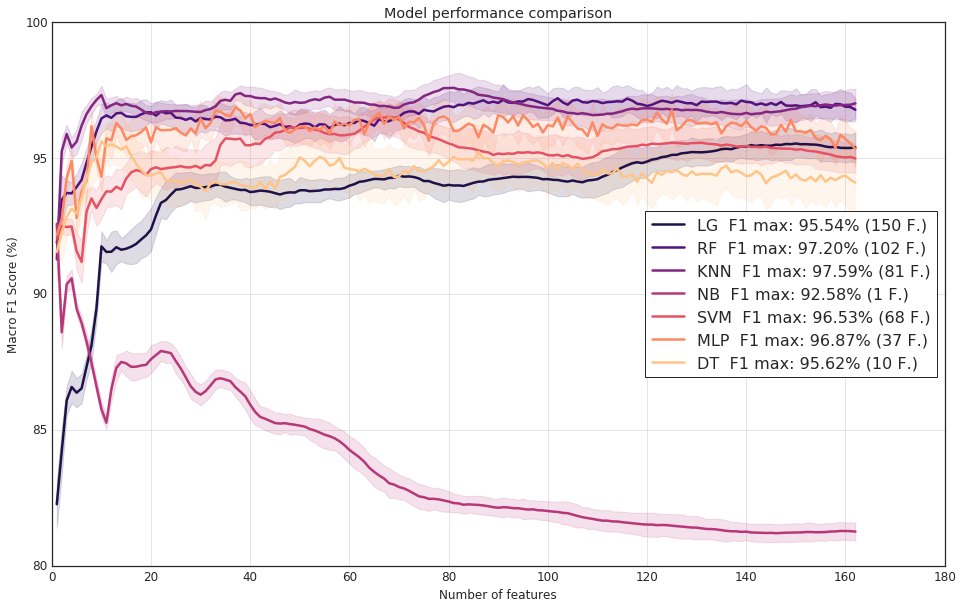

In [9]:

#Mean values
with open(mean_file, 'r') as f:
    array_dict = f.read() 

adict = ast.literal_eval(array_dict) 
array_dict=adict


#Std values
with open(std_file, 'r') as f:
    array_dict_std = f.read() 

adict_std = ast.literal_eval(array_dict_std) 
array_dict_std=adict_std



#Set figure style
plt.figure()   
i=0

#Plot colors
colors= [(0.113094, 0.065492, 0.276784), 
         (0.316654, 0.07169, 0.48538), 
         (0.512831, 0.148179, 0.507648), 
         (0.716387, 0.214982, 0.47529), 
         (0.904281, 0.31961, 0.388137), 
         (0.9867, 0.535582, 0.38221), 
         (0.996898, 0.769591, 0.534892)]


plt.figure(figsize=(16,10))
def set_style():
    plt.style.use(['classic', 'seaborn-white'])
    plt.grid()
    
set_style()



#Plot average f1 evolution
for key, values in array_dict.items(): 
    x = range(0,len(values))
    plt.legend(ncol=1)
    title = "Model performance comparison"
    plt.title(title)
    plt.xlabel("Number of features")
    plt.ylabel("Macro F1 Score (%)")
    optime_features =((np.asarray(values).argmax()+1))
    #Add max f1 value legend
    label=str(key) + "  F1 max: %0.2f%% " %np.max(values) + "(%s " %optime_features + "F.)"
    plt.plot(range(1, len(values)+1),  values, c=colors[i], linewidth=2.5, label=label)
    i+=1

lgnd = plt.legend(bbox_to_anchor=(0.48, -0.2), frameon=True, ncol=2,loc='best', fontsize=16)
plt.legend()

  
    
#Plot std values region
i=0
for std, mean in zip(array_dict_std.items(),array_dict.items()) : 
    x = range(0,len(mean))
    std_low=[x - y for x, y in zip(mean[1],std[1])]
    std_high=[x + y for x, y in zip(mean[1],std[1])]
    plt.fill_between(range(1, len(std[1])+1), std_high, std_low, color=colors[i], alpha=.15)
    i+=1

lgnd = plt.legend(bbox_to_anchor=(0.48, -0.2), frameon=True, ncol=2, loc =9, fontsize=16)
plt.legend(frameon=True, loc ='best', fontsize=16)

#Save Image
plt.savefig('Comparative_f1_feat.png', bbox_inches='tight',dpi=600)  

#Show Image
plt.show()


## Recall, precission, F1, accuraccy metrics calculation

In [10]:
#Array to calculate a specific number of features 

best_features_num=[3,10,all_features]

f1_score_array_LG_pre, f1_score_array_RF_pre, f1_score_array_KNN_pre, f1_score_array_NB_pre, f1_score_array_SVM_pre, f1_score_array_MLP_pre, f1_score_array_DT_pre = [], [], [], [], [], [], []
f1_score_array_LG, f1_score_array_RF, f1_score_array_KNN, f1_score_array_NB, f1_score_array_SVM, f1_score_array_MLP, f1_score_array_DT = [], [], [], [], [], [], []

recall_scores, precision_scores, accuracy_scores, f1_scores = [],[],[],[]

for n_features in best_features_num:
    select_feature = SelectKBest(chi2, k=n_features)
    print ('----------------------------- ')
    print ('---Number of Features %0.0f-----' % n_features)
    print ('----------------------------- ')
    print('\n')

    for item, item_name in zip(alg_array, alg_array_names): 
        print ('########### ' + str(item_name) + ' ##########')
        for score in scoring:
            pipe = Pipeline([('Feature selection',select_feature), ('Algorithm',item)])
            for n in range(0,n_times):
                kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=n)
                scores = cross_val_score(pipe, wrist_X, wrist_Y, cv =kf, scoring = score)
                average_score = (np.mean(scores)*100)
                array_dict_pre[item_name].append(average_score)
            print(str(score) + ' - ' '%.2f (SD %.3f)' % (np.mean(array_dict_pre[item_name]), np.std(array_dict_pre[item_name])))
            array_dict_pre[item_name]=[]
        print('\n')


----------------------------- 
---Number of Features 3-----
----------------------------- 


########### LG ##########
recall_macro - 82.87 (SD 0.612)
precision_macro - 91.03 (SD 0.374)
f1_macro - 86.09 (SD 0.513)
accuracy - 94.77 (SD 0.151)


########### RF ##########
recall_macro - 93.18 (SD 0.496)
precision_macro - 94.54 (SD 0.543)
f1_macro - 93.72 (SD 0.430)
accuracy - 97.41 (SD 0.180)


########### KNN ##########
recall_macro - 95.61 (SD 0.271)
precision_macro - 96.33 (SD 0.534)
f1_macro - 95.89 (SD 0.366)
accuracy - 98.29 (SD 0.163)


########### NB ##########
recall_macro - 96.22 (SD 0.329)
precision_macro - 86.48 (SD 0.402)
f1_macro - 90.36 (SD 0.315)
accuracy - 95.33 (SD 0.163)


########### SVM ##########
recall_macro - 92.10 (SD 0.427)
precision_macro - 93.11 (SD 0.323)
f1_macro - 92.47 (SD 0.308)
accuracy - 96.88 (SD 0.119)


########### MLP ##########
recall_macro - 94.57 (SD 0.573)
precision_macro - 94.17 (SD 0.709)
f1_macro - 94.26 (SD 0.556)
accuracy - 97.56 (SD 0.244)
